In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import sys
sys.settrace
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
import glob
import h5py
from scipy.interpolate import griddata
import scipy.integrate as integrate


#import matplotlib as mpl
#mpl.use("pgf")
#pgf_with_custom_preamble = {
#    "font.family": "serif", # use serif/main font for text elements
#    "text.usetex": True,    # use inline math for ticks
#    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
#    "pgf.preamble": [
#         r"\usepackage{units}",         # load additional packages
#         r"\usepackage{metalogo}",
#         r"\usepackage{unicode-math}",  # unicode math setup
#         r"\setmathfont{xits-math.otf}",
#         r"\setmainfont{DejaVu Serif}", # serif font via preamble
#         r"\usepackage{sfmath} \boldmath",
#         ]
#}

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["DejaVu Serif"]})
# for Palatino and other serif fonts use:
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Palatino"],
#})

plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
plt.rcParams['font.size'] = '20'

from importlib import reload

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_75965/2115520317.py:46: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [2]:
import athena_read

In [3]:
#This is the integral of blackbody from 0 to nu_t (h\nu/kT)
def FitBlackBody(nu_t):
    integral = 0.0;
    nu_2 = nu_t * nu_t;
    nu_3 = nu_t * nu_2;
    nu_7 = nu_2 * nu_2 * nu_3
    if nu_t < 1.8:
        integral = 0.051329911273422 * nu_3 -0.019248716727533 * nu_t * nu_3 + 0.002566495563671 * nu_2 * nu_3
        -3.055351861513195*1.e-5*nu_7
    elif nu_t < 18.6:
        exp_nu = exp(-nu_t);
        integral = -0.156915538762850 * exp_nu * (nu_3 + 2.69 * nu_2 + 6.714 * nu_t) + 1.000009331428801*(1- exp_nu);
    else:
        integral = 1.0 - 192.1*exp(-0.9014*nu_t)

    return integral;
#This is the blackbody spectrum for each frequency nu_t (h\nu/kT)
def BlackBody(nu, tr):
    nu_t=nu/tr
    exp_1=exp(nu_t)-1
    if nu_t < 1.e-5:
      exp_1=tr**3.0*nu_t**2.0
    else:
      exp_1=nu**3.0/exp_1

    spec=(15/np.pi**4.0)*exp_1

    return spec;

def BlackBodyNnu2(nu, tr):
    nu_t=nu/tr
    exp_1=exp(nu_t)-1
    if nu_t < 1.e-5:
        exp_1=tr**2.0*(nu_t-0.5*nu_t**2.0)
    else:
        exp_1=1/exp_1

    spec=exp_1

    return spec;
def ConvertJNNu2(bbj, nu_f):
    jnu4=bbj/nu_f**4
    log_jnu4=log10(jnu4)
    log_nnu2=1
    if log_jnu4 < -3.99793:
        log_nnu2 = 0.9971*log_jnu4+0.7464
    elif log_jnu4 >= -3.99793 and log_jnu4 < 2.73043:
        jsq = log_jnu4*log_jnu4
        log_nnu2 = 0.0003484*jsq*jsq+0.002327*jsq*log_jnu4-0.02137*jsq+0.8037*log_jnu4+0.3249
    else:
        log_nnu2 = 0.7506*log_jnu4+0.3773
    nnu2 = 10.0**log_nnu2*nu_f*nu_f*nu_f
    return nnu2
def ConvertJNNu2Wein(bbj, nu_f, tgas):
    nu_t=nu_f/tgas
    n_coef = 2.0+2.0*nu_t+nu_t*nu_t
    j_coef = 6.0+6.0*nu_t+3.0*nu_t*nu_t+nu_t*nu_t*nu_t
    nnu2 = bbj*np.pi**4.0*n_coef/(15.0*tgas*j_coef)
    return nnu2

In [17]:
def PlotProfile(datax, datay, xmin, xmax, ymin, ymax,  ylabel, label1, filename, xlabel='$r/r_g$', logscale=0, 
                xlogscale=0, datax1_2=None, datay1_2=None, datay1_3=None, datax2=None, datay2=None, datax2_2=None, 
                datay2_2=None, datay2_3=None, datax3=None, datay3=None, datax3_2=None, datay3_2=None, datay3_3=None, 
                datax4=None, datay4=None, datax4_2=None, datay4_2=None, datax5=None, datay5=None, label2='', 
                label2_2='',label3='', label4='', label5='',title=None,leg_loc=None):
    plots, axes = plt.subplots(figsize=(9,11),dpi=300)
    plt.xlabel(xlabel, size = 30)
    plt.ylabel(ylabel, size = 30)
    plt.subplots_adjust(left=0.15,right=0.88,top=0.9,bottom=0.1)
    plt.ylim([ymin,ymax])
    plt.xlim([xmin,xmax])
    if logscale > 0:
      axes.set_yscale('log')
    if xlogscale > 0:
      axes.set_xscale('log')
    if title is not None:
      plt.title(title,size=20)

    plt.plot(datax,datay,color='black',label=label1,linewidth=3.0)
    if datay1_2 is not None:
        if datax1_2 is not None:
            plt.scatter(datax1_2,datay1_2,s=80,facecolors='none', edgecolors='black')
        else:
            plt.scatter(datax1,datay1_2,s=80,facecolors='none', edgecolors='black')    
    if datay1_3 is not None:
        plt.plot(datax,datay1_3,color='black',linestyle='dashed',linewidth=4.0)
    if datay2 is not None:
        plt.plot(datax2,datay2,color='red',label=label2,linewidth=3.0)
    if datay2_2 is not None:
        if datax2_2 is not None:
            plt.plot(datax2_2,datay2_2,color='blue',label=label2_2,linewidth=3.0,linestyle='dashed')
        else:
            plt.plot(datax2,datay2_2,color='red',label=label2,linewidth=3.0)      
    if datay2_3 is not None:
        plt.plot(datax2,datay2_3,color='red',linestyle='dashed',linewidth=4.0)
    if datay3 is not None:
        plt.plot(datax3,datay3,color='green',label=label3,linewidth=3.0,linestyle='dashed')
    if datay3_2 is not None:
        if datax3_2 is not None:
            plt.scatter(datax3_2,datay3_2,s=80,facecolors='none', edgecolors='green')
        else:
            plt.scatter(datax3_2,datay3_2,s=80,facecolors='none', edgecolors='green')          
    if datay3_3 is not None:
        plt.plot(datax3,datay3_3,color='green',linestyle='dashed',linewidth=4.0)
    if datay4 is not None:
        plt.plot(datax4,datay4,color='blue',label=label4,linewidth=3.0)
        if datax4_2 is not None:
            plt.scatter(datax4_2,datay4_2,s=80,facecolors='none', edgecolors='blue')
        else:
            plt.scatter(datax4,datay4_2,s=80,facecolors='none', edgecolors='blue')
    if datay5 is not None:
      plt.plot(datax5,datay5,color=tableau20[0],label=label5,linewidth=2.0) 
    if leg_loc is not None:
      plt.legend(loc="best",bbox_to_anchor=leg_loc,frameon=False)
    axes.set_aspect('auto')
#    axes.yaxis.set_tick_params(labelsize=25)
#    axes.xaxis.set_tick_params(labelsize=25)
    plt.savefig(filename)
    plt.close(plots)


In [5]:
files=sorted(glob.glob('Data/thermal*athdf'))
num_file=len(files)

In [6]:
#for filename in files:
ang_file = open('Data/Rad_angles.txt', 'r')
Lines = ang_file.readlines()
angle_line = [ line for line in Lines if  "tau_scheme" in line]
angle_line=angle_line[0]

prat_line = [ line for line in Lines if  "Prat" in line]
prat_line=prat_line[0]
prat_split=prat_line.split(" ")
Prat=float(prat_split[size(prat_split)-2])


crat_line = [ line for line in Lines if  "Crat" in line]
crat_line=crat_line[0]
Crat_split=crat_line.split(" ")
Crat=float(Crat_split[size(Crat_split)-2])


angle_index=Lines.index(angle_line)+1
location=Lines.index('fre   spec\n')
tot_line=size(Lines)
nfreq=tot_line-location-1
nu_grid=np.zeros(nfreq)
histories=np.zeros((num_file,52))
for i in range(nfreq):
    line=Lines[i+location+1].split(' ')[0]
    nu_grid[i]=float(line)

nu_center=np.zeros(nfreq-1)
nu_center[:]=(nu_grid[:-1]+nu_grid[1:])/2

nu_plot=np.zeros(nfreq)
nu_plot[:-1]=nu_center
nu_plot[nfreq-1]=nu_grid[nfreq-1]

#nu_center=np.append(nu_center,nu_grid[nfreq-1])
nang=location-angle_index
mu_x=np.zeros(nang)
mu_y=np.zeros(nang)
mu_z=np.zeros(nang)
weight=np.zeros(nang)
for n in range(nang):
    line=Lines[n+angle_index].split('   ')
    mu_x[n]=float(line[1])
    mu_y[n]=float(line[2])
    mu_z[n]=float(line[3])
    weight[n]=float(line[4].rstrip())

In [7]:
tgas=np.zeros(num_file)
er_spec=np.zeros((num_file,nfreq))
specific_spec=np.zeros((num_file,nfreq-1))
time=np.zeros(num_file)
er_his=np.zeros(num_file)

In [8]:
for i in range(num_file):
    filename=files[i]
    with h5py.File(filename, 'r') as f:
        attributes = f.attrs.items()
        attrs = dict(attributes)
        level = f.attrs['MaxLevel']
        time[i] = f.attrs['Time']
        subsample = False
    data = athena_read.athdf(filename, level=level, subsample=subsample)
    tgas[i]=np.mean(data['press'][0,0,:]/data['rho'][0,0,:])
    er_his[i]=0.0
    for j in range(nfreq):
        varname='Er_'+str(j)
        er_spec[i,j]=np.mean(data[varname][0,0,:])
        er_his[i] = er_his[i] + er_spec[i,j]
    for j in range(nfreq-1):
        specific_spec[i,j]= er_spec[i,j]/(nu_grid[j+1]-nu_grid[j])

In [9]:
print(tgas)
print(er_his)
print(er_his[1]**0.25)
print(Prat*er_his[0]+tgas[0]/(5/3-1))
print(Prat*er_his[num_file-1]+tgas[num_file-1]/(5/3-1))

ntot_0=0
for i in range(nfreq-1):
    ntot_0=ntot_0+er_spec[0,i]*(np.pi**4/15.0)/nu_center[i]
nnu2_last0=ConvertJNNu2Wein(er_spec[0,nfreq-1], nu_grid[nfreq-1], tgas[0])
ntot_0=ntot_0+nnu2_last0
print(ntot_0)

[100.          69.16355133  68.45209503  68.44812775  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808197  68.44808197  68.44808197  68.44808197  68.44808197
  68.44808

In [10]:
Te=5.94065e9/1.e4
tini=1
ntot=integrate.quad(BlackBodyNnu2,0,inf,args=(tini,))[0]
tfinal=tgas[num_file-1]
nt3=ntot_0/tfinal**3
if nt3>= 2.3739:
    coef=1
elif nt3 < 2.3739 and nt3 >= 0.6932:
    coef=1.948*nt3**(-1.016)+0.1907
else:
    coef=(1+(1+nt3*0.25)**0.5)/nt3
print(coef,tfinal,nu_grid[nfreq-1])

267034.7174408773 68.44808197021484 100.0


/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_75965/104872166.py:32: RuntimeWarning: overflow encountered in exp
  exp_1=exp(nu_t)-1


In [11]:
ntot_i=0
for i in range(nfreq-1):
    ntot_i=ntot_i+er_spec[num_file-1,i]*(np.pi**4/15.0)/nu_center[i]
    
nnu2_last=ConvertJNNu2Wein(er_spec[num_file-1,nfreq-1], nu_grid[nfreq-1], tgas[num_file-1])
print(er_spec[num_file-1,nfreq-1],nu_grid[nfreq-1])
print(ntot_0,ntot_i,nnu2_last,er_spec[num_file-1,nfreq-1])

82.36282348632812 100.0
2.4018524246196513 0.5022878959417099 2.270273752951898 82.36282348632812


In [12]:
steady_sol=np.zeros(nfreq-1)
for i in range(nfreq-1):
    steady_sol[i]=(15.0/np.pi**4)*nu_center[i]**3/(coef*exp(nu_center[i]/tfinal)-1)
def sol_fun(fre):
    return (15.0/np.pi**4)*fre**3/(coef*exp(fre/tfinal)-1)
integral_sol=np.zeros(nfreq)

for i in range(nfreq-1):
    integral_sol[i]=integrate.quad(sol_fun,nu_grid[i],nu_grid[i+1])[0]
integral_sol[nfreq-1]=integrate.quad(sol_fun,nu_grid[nfreq-1],inf)[0]

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_75965/1464477926.py:5: RuntimeWarning: overflow encountered in exp
  return (15.0/np.pi**4)*fre**3/(coef*exp(fre/tfinal)-1)


0.009999999776482582


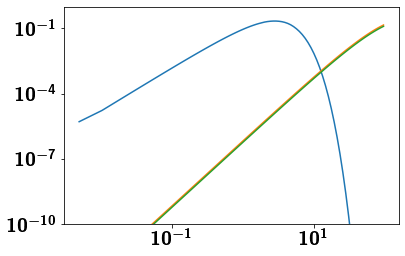

In [13]:
plt.plot(nu_center,specific_spec[0,:])
plt.plot(nu_center,specific_spec[num_file-1,:])
plt.plot(nu_center,steady_sol)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-10,1)
print(time[num_file-1])

(1e-10, 120)

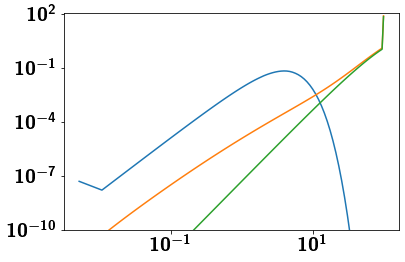

In [14]:
plt.plot(nu_plot,er_spec[0,:])
plt.plot(nu_plot,er_spec[1,:])
plt.plot(nu_plot,integral_sol)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-10,120)

In [ ]:
ylabel='$J_{\\nu}$'
filename='compton_thermalization.pdf'
xlabel="$\\nu$"
label2='$t=0.005$'
label3='$y=1$'
label4='$y=10$'
#print(histories[:,0])
PlotProfile(nu_center,specific_spec[0,:],5.e-3, 120, 1.e-14, 1, ylabel, '$t=0$',filename, xlabel,logscale=1,
            xlogscale=1,
            datax2=nu_center,datay2=specific_spec[num_file-1,:], label2=label2,
           datax2_2=nu_center,datay2_2=steady_sol,label2_2='$Analytical\ \ Solution$',leg_loc=(0.32,0.3))

In [16]:
ylabel='$T_g,\ E_r^{1/4}$'
filename='energy_history.pdf'
xlabel="$t$"
label2='$E_r^{1/4}$'
label3='$y=1$'
label4='$y=10$'
#print(histories[:,0])
PlotProfile(time,tgas,0, 1.e-3, 0.5, 110, ylabel, '$T_g$',filename, xlabel,logscale=1,
            xlogscale=0,
            datax2=time,datay2=er_his**0.25, label2=label2,leg_loc=(0.9,0.2))